In [36]:
import os
import pandas as pd
from IPython.display import Audio
from IPython.display import Image
from IPython.display import SVG
from IPython.display import SVG, display
from IPython.core.display import HTML 
from IPython.display import Image
from IPython.core.display import HTML 
from IPython.core.display import Image, display
import matplotlib.cm as cm

from torch.autograd import Variable
from IPython.display import Audio
import IPython.display

import phonemizer
import torch

from data import *
from model import Loop
from utils import generate_merlin_wav

In [2]:
%matplotlib inline
import IPython.display
from ipywidgets import interact, interactive, fixed

import numpy as np
import matplotlib.pyplot as plt
import copy
from scipy.io import wavfile
#from scipy.signal import butter, lfilter
#import scipy.ndimage
import os
import argparse

#import spectrograms.spectrogram_utils as su

#import winsound
import pandas as pd

import glob as gl
from IPython.display import display, HTML

import pydub as pyd
import spectrogram as sp
from utils import generate_merlin_wav

%load_ext autoreload
%autoreload 2

/usr/local/lib/python2.7/dist-packages/pydub/utils.py:165: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [3]:
os.chdir('/home/ubuntu/loop')
vctk_folder = '/home/ubuntu/VCTK-Corpus/'

In [4]:
def get_vtck_speaker_info():
    # this is the reference data file that comes as part of VCTK
    speaker_info_file = os.path.join(vctk_folder, 'speaker-info.txt')

   # read file contents
    f = open(speaker_info_file, 'r')
    x = f.readlines()
    f.close()

    # extract column headers
    cols = x[0].lower().split()
    num_cols = len(cols)
    del x[0]
    num_speaker = len(x)

    # parse the data line by line
    d = dict()

    for idx in range(num_speaker):
        this_speaker_id = int(x[idx][:3])
        this_age = int(x[idx][5:7])
        this_gender = x[idx][9]
        residual = x[idx][14:].split()
        this_accent = residual[0]
        this_region = " ".join(residual[1:])

        # add speakers to a dictionary
        d[this_speaker_id] = (this_speaker_id, this_age, this_gender, this_accent, this_region)

    # convert to Pandas datafrae
    speaker_info = pd.DataFrame.from_dict(d, orient='index', columns=cols)
    
    return speaker_info

In [5]:
from IPython.display import SVG
def show_svg():
    return SVG(url='http://upload.wikimedia.org/wikipedia/en/a/a4/Flag_of_the_United_States.svg')

In [6]:
def plot_spectrogram(wav_data, rate, title="Original Spectrogram"):
    ### Parameters ###
    fft_size = 480# 2048 # window size for the FFT
    #step_size = int(fft_size/16) # distance to slide along the window (in time)
    step_size = 160 # distance to slide along the window (in time)
    spec_thresh = 4 # threshold for spectrograms (lower filters out more noise)
    lowcut = 500 # Hz # Low cut for our butter bandpass filter
    highcut = 7500 #15000 # Hz # High cut for our butter bandpass filter

    # For mels
    n_mel_freq_components = 40# 64 # number of mel frequency channels
    shorten_factor = 1#10 # how much should we compress the x-axis (time)
    start_freq = 300 # Hz # What frequency to start sampling our melS from 
    end_freq = 8000 # Hz # What frequency to stop sampling our melS from

    data = sp.butter_bandpass_filter(wav_data, lowcut, highcut, rate, order=1)
    #data = butter_bandpass_filter(data, 500, 7500, rate, order=1)
    # Only use a short clip for our demo
    if np.shape(data)[0]/float(rate) > 10:
        data = data[0:rate*10] 
    #print('Length in time (s):' + str(np.shape(data)[0]/float(rate)))

    wav_spectrogram = sp.pretty_spectrogram(wav_data.astype('float64'), fft_size = fft_size, 
                                       step_size = step_size, log = True, thresh = spec_thresh)

    fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,4))
    cax = ax.matshow(np.transpose(wav_spectrogram), interpolation='nearest', aspect='auto', cmap=plt.cm.afmhot, origin='lower')
    fig.colorbar(cax)
    plt.title(title)
    #plt.xlim(0, len(wav_data))
    #plt.xticks(range(0,len(wav_data), 48000), range(0, np.int(np.ceil(1.0*len(wav_data)/48000))))

def load_pre_calc_features(speaker_id, sample_id):
    pre_calc_features_folder = '/home/ubuntu/loop/data/vctk/numpy_features/'
    pre_calc_features_file = os.path.join(pre_calc_features_folder, 
                                      'p' + str(speaker_id) + '_' + '{num:03d}'.format(num=sample_id) + '.npz')
    
    feats = np.load(pre_calc_features_file)
    
    return feats

def play_synthesized_features(feats):
    output_dir = './'
    output_file = 'test.wav'
    norm_path = '/home/ubuntu/loop/data/vctk/norm_info/norm.dat'
    generate_merlin_wav(feats['audio_features'],
                        output_dir,
                        output_file,
                        norm_path)

    IPython.display.display(IPython.display.Audio(output_file + '.wav', autoplay=True))
    
    rate, wav_data = wavfile.read(output_file + '.wav')  
    
    return rate, wav_data

In [7]:
def play_vctk_sample(vctk_speaker_id, sample_id):
    # raw .wav file
    wav_file = os.path.join(vctk_folder, 'wav48/p' + str(vctk_speaker_id) + '/p' + str(vctk_speaker_id) + '_' + '{num:03d}'.format(num=sample_id) + '.wav')

    # print speaker info
    display(speaker_info[speaker_info['id']==vctk_speaker_id])

    # print text
    txt_file = wav_file.replace("wav48", "txt").replace(".wav", ".txt")
    f = open(txt_file, 'r')
    print(f.read())
    f.close()
    
    x = feats['phonemes']
    #x[x==42] = 0 # for some reason, sometimes there is a phoneme with index=42, which doesn't appear in the dict.
    print " ".join(feats['code2phone'][x])

    # play sample
    rate, wav_data = wavfile.read(wav_file)    
    display(IPython.display.Audio(data=wav_data, rate=rate, autoplay=True))

In [8]:
def plot_lf0_etc(feats):
    # plot lf0, vuv and bap features
    plt.figure(figsize=(20, 4))

    plt.subplot(1, 3, 1)
    plt.plot(feats['audio_features'][:, 60])
    plt.title('vuv')
    plt.grid(True)

    plt.subplot(1, 3, 2)
    plt.plot(feats['audio_features'][:, 61])
    plt.title('lf0')
    plt.grid(True)

    plt.subplot(1, 3, 3)
    plt.plot(feats['audio_features'][:, 62])
    plt.title('bap')
    plt.grid(True)

In [9]:
def display_vctk_sample(vctk_speaker_id, sample_id):
    # raw .wav file
    wav_file = os.path.join(vctk_folder, 'wav48/p' + str(vctk_speaker_id) + '/p' + str(vctk_speaker_id) + '_' + '{num:03d}'.format(num=sample_id) + '.wav')

    # print speaker info
    display(speaker_info[speaker_info['id']==vctk_speaker_id])

    # print text
    txt_file = wav_file.replace("wav48", "txt").replace(".wav", ".txt")
    f = open(txt_file, 'r')
    print(f.read())
    f.close()

    # play sample
    rate, wav_data = wavfile.read(wav_file)    
    display(IPython.display.Audio(data=wav_data, rate=rate, autoplay=True))

    # plot waveform
    plt.figure(figsize=(15,4))
    plt.plot(wav_data)
    plt.grid(True)
    plt.xlim(0, len(wav_data))
    plt.xticks(range(0,len(wav_data), 48000), range(0, np.int(np.ceil(1.0*len(wav_data)/48000))))

    # plot spectrogram
    plot_spectrogram(wav_data, rate)

def plot_spectrogram(wav_data, rate, title="Original Spectrogram"):
    ### Parameters ###
    fft_size = 480# 2048 # window size for the FFT
    #step_size = int(fft_size/16) # distance to slide along the window (in time)
    step_size = 160 # distance to slide along the window (in time)
    spec_thresh = 4 # threshold for spectrograms (lower filters out more noise)
    lowcut = 500 # Hz # Low cut for our butter bandpass filter
    highcut = 7500 #15000 # Hz # High cut for our butter bandpass filter

    # For mels
    n_mel_freq_components = 40# 64 # number of mel frequency channels
    shorten_factor = 1#10 # how much should we compress the x-axis (time)
    start_freq = 300 # Hz # What frequency to start sampling our melS from 
    end_freq = 8000 # Hz # What frequency to stop sampling our melS from

    data = sp.butter_bandpass_filter(wav_data, lowcut, highcut, rate, order=1)
    #data = butter_bandpass_filter(data, 500, 7500, rate, order=1)
    # Only use a short clip for our demo
    if np.shape(data)[0]/float(rate) > 10:
        data = data[0:rate*10] 
    #print('Length in time (s):' + str(np.shape(data)[0]/float(rate)))

    wav_spectrogram = sp.pretty_spectrogram(wav_data.astype('float64'), fft_size = fft_size, 
                                       step_size = step_size, log = True, thresh = spec_thresh)

    fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,4))
    cax = ax.matshow(np.transpose(wav_spectrogram), interpolation='nearest', aspect='auto', cmap=plt.cm.afmhot, origin='lower')
    fig.colorbar(cax)
    plt.title(title)
    #plt.xlim(0, len(wav_data))
    #plt.xticks(range(0,len(wav_data), 48000), range(0, np.int(np.ceil(1.0*len(wav_data)/48000))))

In [10]:
 def plot_spectrogram_comparison(wav_file_a, wav_file_b, label_a='base', label_b='test',
                                 title="Original Spectrogram", b_mel=False):
        
    ### Parameters ###
    fft_size = 480# 2048 # window size for the FFT
    #step_size = int(fft_size/16) # distance to slide along the window (in time)
    step_size = 160 # distance to slide along the window (in time)
    spec_thresh = 4 # threshold for spectrograms (lower filters out more noise)
    lowcut = 500 # Hz # Low cut for our butter bandpass filter
    highcut = 7500 #15000 # Hz # High cut for our butter bandpass filter

    # For mels
    n_mel_freq_components = 40# 64 # number of mel frequency channels
    shorten_factor = 1#10 # how much should we compress the x-axis (time)
    start_freq = 300 # Hz # What frequency to start sampling our melS from 
    end_freq = 8000 # Hz # What frequency to stop sampling our melS from

    #loop_dict['output_orig_fname']
    #loop_dict['output_fname']
    
    # load wav file data
    mywav_a = wav_file_a + '.wav'
    mywav_b = wav_file_b + '.wav'
    
    rate_a, data_a = wavfile.read(mywav_a)
    data_a = sp.butter_bandpass_filter(data_a, lowcut, highcut, rate_a, order=1)
    
    rate_b, data_b = wavfile.read(mywav_b)
    data_b = sp.butter_bandpass_filter(data_b, lowcut, highcut, rate_b, order=1)
    
    assert rate_a==rate_b, "Sampling rates don't match"
    
    # pad
    max_len = np.max([len(data_a), len(data_b)])
    
    tmp_a = data_a
    data_a = np.zeros(max_len)
    data_a[:len(tmp_a)] = tmp_a
    
    tmp_b = data_b
    data_b = np.zeros(max_len)
    data_b[:len(tmp_b)] = tmp_b
   

    # create spectrograms
    wav_spectrogram_a = sp.pretty_spectrogram(data_a.astype('float64'), fft_size = fft_size, 
                                           step_size = step_size, log = True, thresh = spec_thresh)

    wav_spectrogram_b = sp.pretty_spectrogram(data_b.astype('float64'), fft_size = fft_size, 
                                           step_size = step_size, log = True, thresh = spec_thresh)
    
    # create mel spectrograms if necessary
    if b_mel:        
         # Generate the mel filters
        mel_filter, mel_inversion_filter = sp.create_mel_filter(fft_size = fft_size,
                                                            n_freq_components = n_mel_freq_components,
                                                            start_freq = start_freq,
                                                            end_freq = end_freq, samplerate=rate_a) # may need to change sample rate
    
        # create mel spectrograms
        mel_spec_a = sp.make_mel(wav_spectrogram_a, mel_filter, shorten_factor = shorten_factor)
        mel_spec_b = sp.make_mel(wav_spectrogram_b, mel_filter, shorten_factor = shorten_factor)
        
        # use mel spectrograms in the plots (hacky, needs tidying up)
        wav_spectrogram_a = np.float64(mel_spec_a)
        wav_spectrogram_b = np.float64(mel_spec_b)

   
    # plot spectrograms and the differences
    f, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,3))
    cax = ax.matshow(np.transpose(wav_spectrogram_a), interpolation='nearest', aspect='auto', cmap=plt.cm.afmhot, origin='lower')
    f.colorbar(cax)
    plt.title('Spectrogram: ' + wav_file_a + '(' + label_a + ')')

    f, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,3))
    cax = ax.matshow(np.transpose(wav_spectrogram_b), interpolation='nearest', aspect='auto', cmap=plt.cm.afmhot, origin='lower')
    f.colorbar(cax)
    plt.title('Spectrogram: ' + wav_file_b + '(' + label_b + ')')

    f, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,3))
    cax = ax.matshow(np.transpose(wav_spectrogram_b - wav_spectrogram_a), interpolation='nearest', aspect='auto', cmap=plt.cm.afmhot, origin='lower')
    f.colorbar(cax)
    plt.title('Difference: (' + wav_file_b + ' - ' + wav_file_a + ') (' + label_b + ' - ' + label_a + ')')

In [11]:
def load_pre_calc_features(speaker_id, sample_id):
    pre_calc_features_folder = '/home/ubuntu/loop/data/vctk/numpy_features/'
    pre_calc_features_file = os.path.join(pre_calc_features_folder, 
                                      'p' + str(speaker_id) + '_' + '{num:03d}'.format(num=sample_id) + '.npz')
    
    feats = np.load(pre_calc_features_file)
    
    return feats

def play_synthesized_features(feats):
    output_dir = './'
    output_file = 'test.wav'
    norm_path = '/home/ubuntu/loop/data/vctk/norm_info/norm.dat'
    generate_merlin_wav(feats['audio_features'],
                        output_dir,
                        output_file,
                        norm_path)

    IPython.display.display(IPython.display.Audio(output_file + '.wav', autoplay=True))
    
    rate, wav_data = wavfile.read(output_file + '.wav')  
    
    return rate, wav_data


In [12]:
def generate_sample_with_loop(npz='', text='', spkr_id=1, checkpoint='models/vctk/bestmodel.pth', output_dir = './',
                             npz_path = '/home/ubuntu/loop/data/vctk/numpy_features'):
    #npz = ''
    #text = 'Your tickets for the social issues'
    #text = 'see that girl watch that scene'
    #npz = '/home/ubuntu/loop/data/vctk/numpy_features/p294_011.npz'
    #spkr_id = 12
    #checkpoint = 'checkpoints/vctk/lastmodel.pth'
    #checkpoint = 'models/vctk/bestmodel.pth'
    
    out_dict = dict()
    
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    gpu = 0

    # load loop weights & params from checkpoint
    weights = torch.load(checkpoint,
                         map_location=lambda storage, loc: storage)
    opt = torch.load(os.path.dirname(checkpoint) + '/args.pth')
    train_args = opt[0]

    train_dataset = NpzFolder('/home/ubuntu/loop/data/vctk/numpy_features')
    char2code = train_dataset.dict
    spkr2code = train_dataset.speakers

    norm_path = train_args.data + '/norm_info/norm.dat'
    norm_path = '/home/ubuntu/loop/data/vctk/norm_info/norm.dat'
    train_args.noise = 0
    
    valid_dataset_path = npz_path + '_valid'

    
    # prepare loop model
    model = Loop(train_args)
    model.load_state_dict(weights)
    if gpu >= 0:
        model.cuda()
    model.eval()

    # check speaker id is valid
    if spkr_id not in range(len(spkr2code)):
        print('ERROR: Unknown speaker id: %d.' % spkr_id)

    # get phone sequence
    txt, feat, spkr, output_fname = None, None, None, None
    if npz is not '':
        # use pre-calculated phonemes etc.
        txt, feat, pre_calc_feat = npy_loader_phonemes(os.path.join(npz_path, npz))

        txt = Variable(txt.unsqueeze(1), volatile=True)
        feat = Variable(feat.unsqueeze(1), volatile=True)
        spkr = Variable(torch.LongTensor([spkr_id]), volatile=True)

        output_file = os.path.basename(npz)[:-4] + '_' + str(spkr_id)
        
        out_dict['pre_calc_feat'] = pre_calc_feat
        
    elif text is not '':
        # use specified text string
        # extract phonemes from the text
        txt = text2phone(text, char2code)
        feat = torch.FloatTensor(txt.size(0)*20, 63)
        spkr = torch.LongTensor([spkr_id])

        txt = Variable(txt.unsqueeze(1), volatile=True)
        feat = Variable(feat.unsqueeze(1), volatile=True)
        spkr = Variable(spkr, volatile=True)

        output_file = text.replace(' ', '_')
    else:
        print('ERROR: Must supply npz file path or text as source.')
        raise Exception('Need source')

    # use gpu
    if gpu >= 0:
        txt = txt.cuda()
        feat = feat.cuda()
        spkr = spkr.cuda()

    # run loop model to generate output features 
    loop_feat, attn = model([txt, spkr], feat)
    loop_feat, attn = trim_pred(loop_feat, attn)
    
    # add to output dictionary
    out_dict['txt'] = txt[:,0].squeeze().data.tolist()
    out_dict['spkr'] = spkr
    out_dict['feat'] = feat.data.cpu().numpy()
    out_dict['loop_feat'] = loop_feat.data.cpu().numpy()
    out_dict['attn'] = attn.squeeze().data.cpu().numpy()
    out_dict['output_file'] = output_file
    out_dict['valid_dataset_path'] = valid_dataset_path
    


    # generate .wav file from loop output features
    generate_merlin_wav(loop_feat.data.cpu().numpy(),
                        output_dir,
                        output_file,
                        norm_path)
    
    
    # generate .wav file from original features for reference
    if npz is not '':
        output_orig_fname = os.path.basename(npz)[:-4] + '.orig'
        generate_merlin_wav(feat[:, 0, :].data.cpu().numpy(),
                            output_dir,
                            output_orig_fname,
                            norm_path)
        out_dict['output_orig_fname'] = output_orig_fname
    
    return out_dict


In [13]:
def plot_attn(data, labels, dict_file):
    labels_dict = dict_file
    labels_dict = {v: k for k, v in labels_dict.iteritems()}
    labels = [labels_dict[x].decode('latin-1') for x in labels]

    plt.figure(figsize=(10,10))
    axarr = plt.subplot()
    axarr.imshow(data.T, aspect='auto', origin='lower', interpolation='nearest', cmap=cm.viridis)
    axarr.set_yticks(np.arange(0, len(data.T)))
    axarr.set_yticklabels(labels, rotation=90)

In [14]:
def text2phone(text, char2code):
    seperator = phonemizer.separator.Separator('', '', ' ')
    ph = phonemizer.phonemize(text, separator=seperator)
    ph = ph.split(' ')
    ph.remove('')

    ph = [p.replace('zh', 'jh') for p in ph]

    result = [char2code[p] for p in ph]
    return torch.LongTensor(result)

def trim_pred(out, attn):
    tq = attn.abs().sum(1).data

    for stopi in range(1, tq.size(0)):
        col_sum = attn[:stopi, :].abs().sum(0).data.squeeze()

        if type(tq[stopi]) == float:
            if tq[stopi] < 0.5 and col_sum[-1] > 4:
                break
        else:  
            if tq[stopi][0] < 0.5 and col_sum[-1] > 4:
                break

    out = out[:stopi, :]
    attn = attn[:stopi, :]

    return out, attn

def npy_loader_phonemes(path):
    feat = np.load(path)

    txt = feat['phonemes'].astype('int64')
    txt = torch.from_numpy(txt)

    audio = feat['audio_features']
    audio = torch.from_numpy(audio)

    return txt, audio, feat

# CSML MSc Project
## Speaker-Adaptive Neural Text-to-Speech Synthesis

### with Papercup



### Agenda:
* Summary of progress so far
* Proposed research agenda
* Feedback!
* Agree next steps & milestones 

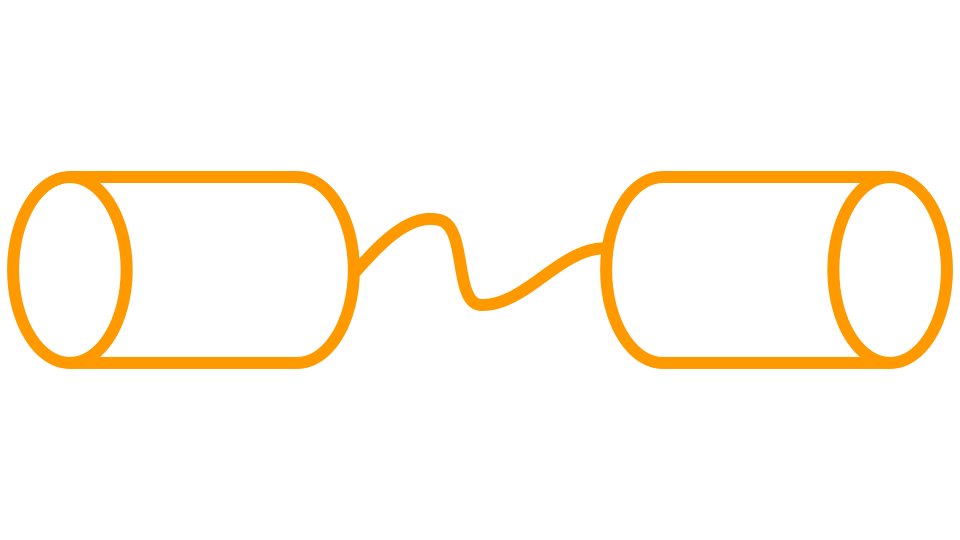

In [15]:
Image("/home/ubuntu/loop/logo.png", width=100, height=100)

# I) Progress So Far

* **Started with Papercup last week**
    - Plan is to be based with them throughout the summer

* **Set up tech/workflow tools**
    - AWS, notebooks, PyCharm

* **Literature review**
    * Using Mendeley

* **Benchmark implementation up & running**
    - Data source, code, sensible results

* **Proposed research agenda**

#### My notes
* Good initial progress
* Built some momentum
* Need guidance on research agenda
* What makes a sensible/good project
* What is expected in terms of write up
<hr>

# II) Literature Review

 * **1) Domain background**
    - Computational linguistics, phonemes, signal processing (spectrograms, MFCCs)

* **2) Traditional approaches to TTS**
    - concatenative vs. statistical parametric

* **3) Sequence to sequence approaches to TTS**
    - Tacotron (WaveNet), DeepVoice, VoiceLoop...        
    - Single speaker vs. multi-speaker (speaker embeddings spaces)

* ** 4) Wider literature on representation learning**
    - VAE: conditional VAE, VQVAE, BetaVAE
    - GAN: icGAN, infoGAN

    - Differ in how 'end-to-end' they are (text features, audio features, vocoder)
    
    - Fader networks
    - Style transfer
        
    - Supervised vs. unsupervised

#### Notes
* Could do various projects in this context...
* Extend framework to new dataset (or new language)
* Or in-the-wild dataset
* Modifications to existing frames (e.g. loss functions)
* My project: 

# III) Proposed Research Agenda
* Start with a benchmark model: **<font color=red>VoiceLoop multi-speaker using VCTK</font>**
    - Released VoiceLoop uses 22 speakers: need to build sim on a larger subset of VCTK

* Investigate speaker embeddings in the benchmark
    - PCA/T-SNE; Interpolation; Learning an embedding for an unseen speaker


* Supervised extension to speaker embeddings: **<font color=red>Fader Networks</font>**
    - Trained to disentangle latent representation of input from labelled attributes
    - Adversarial network that tries to identify labels of an example given the latent representation  

* Unsupervised extentsion to speaker embeddings: **<font color=red>BetaVAE</font>**
    - Hyperparameter that trades off reconstruction accuracy vs. distentangled latent factors
    - Does it learn the factors from the supervised case (gender, accent) but without using labels?
    - Does it learn additional factors e.g. depth of voice?

* Use techniques from 4) to learn and control speaker characterstics
   - Use labels supplied in the VCTK dataset
   
      - Add term to loss function to force speaker embedding layer to learn a representation from which adversarial network can't recover the labelsEncoder-decoder 

# IV) Benchmark VoiceLoop Implementation
* Facebook AI Research published the original VoiceLoop paper in July 2017
* Sequence to sequence model with attention
    - Inputs: `(phonemes, speaker_id)`
    - Targets: `WORLD features`
    - Encoder: lookup up tables for phonemes and speakers
    - Attention: Gaussian mixture model
    - Decoder: FIFO memory buffer
* VCTK dataset

## VCTK Dataset
* Multispeaker English voice dataset
* ~400 sentences per speaker
* Each example consists of `(wav_file, text_transcript, speaker_id)`
* University of Edinburgh's Cente for Speech Technology Research

In [16]:
speaker_info = get_vtck_speaker_info()

In [17]:
print "Number of Speakers: " + str(len(speaker_info))
display(speaker_info.iloc[10:25])

Number of Speakers: 108


,id,age,gender,accents,region
236,236,23,F,English,Manchester
237,237,22,M,Scottish,Fife
238,238,22,F,NorthernIrish,Belfast
239,239,22,F,English,SW England
240,240,21,F,English,Southern England
241,241,21,M,Scottish,Perth
243,243,22,M,English,London
244,244,22,F,English,Manchester
245,245,25,M,Irish,Dublin
246,246,22,M,Scottish,Selkirk


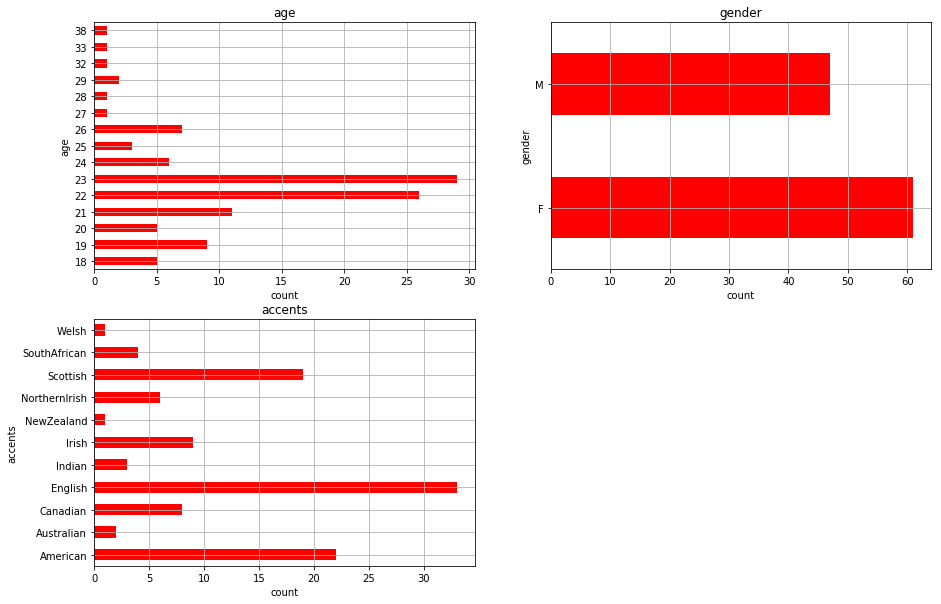

In [18]:
# plot descriptive statistics of speakers
plt.figure(figsize=(15,10))

for i, c in enumerate(['age', 'gender', 'accents']):
    plt.subplot(2,2,i+1)
    speaker_info[c].value_counts().sort_index().plot(kind='barh', color='red', grid=True, title=c)
    plt.xlabel('count')
    plt.ylabel(c)

In [37]:
display(speaker_info.iloc[10:25])

# set speaker here
speaker_id = 301

,id,age,gender,accents,region
236,236,23,F,English,Manchester
237,237,22,M,Scottish,Fife
238,238,22,F,NorthernIrish,Belfast
239,239,22,F,English,SW England
240,240,21,F,English,Southern England
241,241,21,M,Scottish,Perth
243,243,22,M,English,London
244,244,22,F,English,Manchester
245,245,25,M,Irish,Dublin
246,246,22,M,Scottish,Selkirk


In [20]:
txt_folder = os.path.join(vctk_folder, 'txt/p' + str(speaker_id))
txt_files = sorted(gl.glob(os.path.join(txt_folder, '*.txt')))

s = []
for t in txt_files:
    f = open(t, 'r')
    s.append(os.path.basename(t).replace('.txt', '') + ': ' + f.read())
    #s.append(f.read())
    #print f.read()
    f.close()

In [38]:
#pd.DataFrame(s, [os.path.basename(t).replace('.txt', '') for t in txt_files])
display(s)

# set sample here
sample_id = 102

['p301_001: Please call Stella.',
 'p301_002: Ask her to bring these things with her from the store.',
 'p301_003: Six spoons of fresh snow peas, five thick slabs of blue cheese, and maybe a snack for her brother Bob.',
 'p301_004: We also need a small plastic snake and a big toy frog for the kids.',
 'p301_005: She can scoop these things into three red bags, and we will go meet her Wednesday at the train station.',
 'p301_006: When the sunlight strikes raindrops in the air, they act as a prism and form a rainbow.',
 'p301_007: The rainbow is a division of white light into many beautiful colors.',
 'p301_008: These take the shape of a long round arch, with its path high above, and its two ends apparently beyond the horizon.',
 'p301_009: There is , according to legend, a boiling pot of gold at one end.',
 'p301_010: People look, but no one ever finds it.',
 'p301_011: When a man looks for something beyond his reach, his friends say he is looking for the pot of gold at the end of the ra

,id,age,gender,accents,region
301,301,23,F,American,North Carolina


I am sure all schools would accept that.


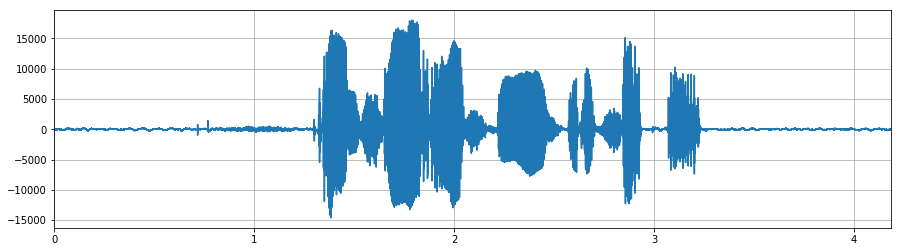

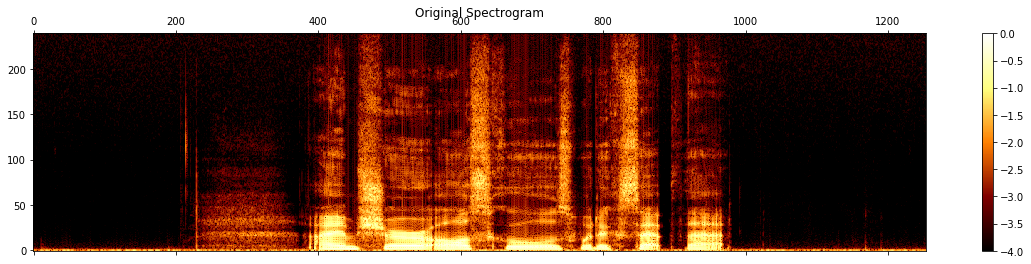

In [40]:
display_vctk_sample(speaker_id, sample_id)

In [23]:
# VoiceLoop only uses the speakers with American accents
speaker_info[speaker_info.accents == 'American']

,id,age,gender,accents,region
294,294,33,F,American,San Francisco
297,297,20,F,American,New York
299,299,25,F,American,California
300,300,23,F,American,California
301,301,23,F,American,North Carolina
305,305,19,F,American,Philadelphia
306,306,21,F,American,New York
308,308,18,F,American,Alabama
310,310,21,F,American,Tennessee
311,311,21,M,American,Iowa


- quick descriptive stats
- show example of labels, say we can use these
- show some examples

## WORLD Features
* WORLD is an open-source speech synthesis system that:
    - 1) Can **analyse** speech data into WORLD features
    - 2) Can **synthesise** WORLD features into synthesized speech


In [24]:
speaker_id = 301
sample_id = 117
# load pre-calculated WORLD features
feats = load_pre_calc_features(speaker_id, sample_id)

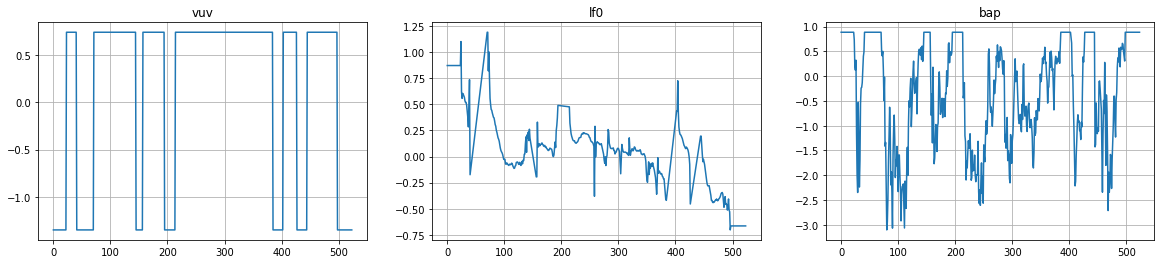

In [25]:
plot_lf0_etc(feats)

#### Original VCTK Sample

In [43]:
speaker_id = 301
sample_id = 117

play_vctk_sample(speaker_id, sample_id)

,id,age,gender,accents,region
301,301,23,F,American,North Carolina


Since then, they have fallen by more than two thirds.
s ih n s dh eh n pau dh ey hh ae v f ao l ax n b ay m ao r dh ae n t uw th er d z


#### Synthesized Voice Using WORLD Features

In [42]:
# load pre-calculated WORLD features
feats = load_pre_calc_features(speaker_id, sample_id)
    
# synthesize sample from features and listen to the resulting .wav file
rate_synth, wav_data_synth = play_synthesized_features(feats)

{'mgc': 0, 'vuv': 60, 'lf0': 61, 'bap': 62}
complete test.wav.wav.


## Benchmark VoiceLoop Results

In [28]:
speaker_list_vctk = [294, 297, 299, 300, 301, 305, 306, 308, 310, 311, 318, 329, 330, 333, 334, 339, 341, 345, 360, 361, 362]
speaker_lookup = dict([(x, y) for x, y in enumerate(speaker_list_vctk)])

In [29]:
def get_npz_file(loop_speaker_id, sample_id):
    # Lookup dict from VCTK speaker IDs to the IDs used inside VoiceLoop
    # should really pick this up from the checkpoints, but it's convenient to have it available before/without a checkpoint being defined
    speaker_list_vctk = [294, 297, 299, 300, 301, 305, 306, 308, 310, 311, 318, 329, 330, 333, 334, 339, 341, 345, 360, 361, 362]
    speaker_lookup = dict([(x, y) for x, y in enumerate(speaker_list_vctk)])

    # load VCTK speaker_info metadata
    speaker_info = get_vtck_speaker_info()
    #speaker_info[speaker_info.id.isin(speaker_lookup.values())]
    tmp = pd.DataFrame.from_dict(speaker_lookup, orient='index', columns=['id'])
    #pd.merge(speaker_info, tmp)

    vctk_source_speaker_id = int(speaker_lookup[loop_speaker_id])
    npz_file= 'p' + str(vctk_source_speaker_id) + '_' + '{num:03d}'.format(num=sample_id) + '.npz'

    # display/listen to the VCTK sample
    #print "Original VCTK .wav File"
    #play_vctk_sample(vctk_source_speaker_id, sample_id)
    
    return npz_file

In [30]:
def play_vctk_version_loop_id(loop_speaker_id, sample_id):
    # Lookup dict from VCTK speaker IDs to the IDs used inside VoiceLoop
    # should really pick this up from the checkpoints, but it's convenient to have it available before/without a checkpoint being defined
    speaker_list_vctk = [294, 297, 299, 300, 301, 305, 306, 308, 310, 311, 318, 329, 330, 333, 334, 339, 341, 345, 360, 361, 362]
    speaker_lookup = dict([(x, y) for x, y in enumerate(speaker_list_vctk)])

    # load VCTK speaker_info metadata
    speaker_info = get_vtck_speaker_info()
    #speaker_info[speaker_info.id.isin(speaker_lookup.values())]
    tmp = pd.DataFrame.from_dict(speaker_lookup, orient='index', columns=['id'])
    #pd.merge(speaker_info, tmp)

    vctk_source_speaker_id = int(speaker_lookup[loop_speaker_id])
    npz_file= 'p' + str(vctk_source_speaker_id) + '_' + '{num:03d}'.format(num=sample_id) + '.npz'

    # display/listen to the VCTK sample
    print "Original VCTK .wav File"
    play_vctk_sample(vctk_source_speaker_id, sample_id)
    return npz_file

#### Generate samples from a model checkpoint...

In [48]:
# generate based on an existing VCTK sample
source_speaker_id = 12
sample_id = 230
text = ''

# speaker id to use for VoiceLoop generation
gen_speaker_id = 9

# model checkpoint
checkpoint = 'checkpoints/vctk-rs/bestmodel.pth'
checkpoint = 'checkpoints/vctk-recover/bestmodel.pth'
checkpoint = 'models/vctk/bestmodel.pth'

output_dir = './'
output_file = 'test.wav'
norm_path = '/home/ubuntu/loop/data/vctk/norm_info/norm.dat'
speaker_info[speaker_info.id==[speaker_lookup[gen_speaker_id]]]

# generate the sample
npz_file =  get_npz_file(source_speaker_id, sample_id)
loop_dict = generate_sample_with_loop(spkr_id=gen_speaker_id, npz=npz_file, text=text, checkpoint=checkpoint)

{'mgc': 0, 'vuv': 60, 'lf0': 61, 'bap': 62}
complete p330_230_9.wav.
{'mgc': 0, 'vuv': 60, 'lf0': 61, 'bap': 62}
complete p330_230.orig.wav.


#### 1) Original VCTK sample

In [32]:
npz_file = play_vctk_version_loop_id(source_speaker_id, sample_id)

Original VCTK .wav File


,id,age,gender,accents,region
330,330,26,F,American,


We talk about Mr Michael Johnson, and he is awesome.
s ih n s dh eh n pau dh ey hh ae v f ao l ax n b ay m ao r dh ae n t uw th er d z


#### 2) WORLD Features

In [33]:
# Play WORLD version
IPython.display.display(Audio(loop_dict['output_orig_fname'] + '.wav', autoplay=True))

#### 3) VoiceLoop Version

In [49]:
# listen to sample synthesized from VoiceLoop features
Audio(loop_dict['output_file'] + '.wav', autoplay=True)

## Attention

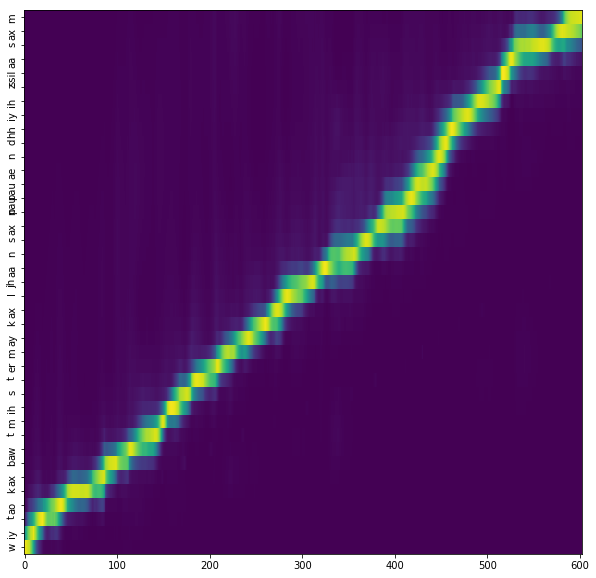

In [35]:
plot_attn(loop_dict['attn'], loop_dict['txt'], NpzFolder(loop_dict['valid_dataset_path']).dict)

# V) Next Steps
* Feedback on the research agenda
* Structure of project report
    - Literature review: useful or just padding?
* Next meeting: Fri 29-June (3 weeks)
* Milestones?